In [21]:
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
from pathlib import Path
from collections import Counter

Defining paths to out datasets

In [2]:
train_dir = Path('./simpsons_dataset/')
test_dir = Path('./testset/')

In [3]:
im_size = 244
imnet_mean = [0.485, 0.456, 0.406]
imnet_std = [0.229, 0.224, 0.225]
batch_size = 64
n_classes = 42

augmentations and transforms

In [4]:
data_augmentations = transforms.Compose([
    transforms.RandomResizedCrop(im_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30)    
    ])

data_transforms = {
    'train': transforms.Compose([
        data_augmentations,
        transforms.ToTensor(),
        transforms.Normalize(imnet_mean, imnet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(im_size),
        transforms.ToTensor(),
        transforms.Normalize(imnet_mean, imnet_std)
    ])
}

## <span style="color:darkred"> TO DO </span>Hist  plot

imbalanced => using WeighedRandomSampler

In [5]:
train_files = sorted(list(train_dir.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(test_dir.rglob('*.jpg')))

In [6]:
pd.Series(train_labels).value_counts()

homer_simpson               2246
ned_flanders                1454
moe_szyslak                 1452
lisa_simpson                1354
bart_simpson                1342
marge_simpson               1291
krusty_the_clown            1206
principal_skinner           1194
charles_montgomery_burns    1193
milhouse_van_houten         1079
chief_wiggum                 986
abraham_grampa_simpson       913
sideshow_bob                 877
apu_nahasapeemapetilon       623
kent_brockman                498
comic_book_guy               469
edna_krabappel               457
nelson_muntz                 358
lenny_leonard                310
mayor_quimby                 246
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
professor_john_frink          65
snake_jail

In [7]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])

In [8]:
class_count = Counter(train_dataset.targets)

In [9]:
class_weight = {i: 1/c for i, c in class_count.items()}
sample_weights = np.zeros(len(train_dataset))

for i, (_, label) in enumerate(tqdm(train_dataset)):
    sample_weights[i] = class_weight[label]
    


  0%|          | 0/20933 [00:00<?, ?it/s]

In [10]:
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

train_loader_without_wrs = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
for i, (_, target) in enumerate(train_loader):
    print(f'batch {i}: {len(pd.Series(target).unique())} unique classes')
    if i == 20:
        break

batch 0: 31 unique classes
batch 1: 31 unique classes
batch 2: 28 unique classes
batch 3: 34 unique classes
batch 4: 34 unique classes
batch 5: 35 unique classes
batch 6: 33 unique classes
batch 7: 36 unique classes
batch 8: 34 unique classes
batch 9: 30 unique classes
batch 10: 35 unique classes
batch 11: 33 unique classes
batch 12: 33 unique classes
batch 13: 32 unique classes
batch 14: 33 unique classes
batch 15: 37 unique classes
batch 16: 34 unique classes
batch 17: 30 unique classes
batch 18: 35 unique classes
batch 19: 35 unique classes
batch 20: 30 unique classes


In [12]:
for i, (_, target) in enumerate(train_loader_without_wrs):
    print(f'batch {i}: {len(pd.Series(target).unique())} unique classes')
    if i == 20:
        break

batch 0: 24 unique classes
batch 1: 23 unique classes
batch 2: 22 unique classes
batch 3: 20 unique classes
batch 4: 23 unique classes
batch 5: 20 unique classes
batch 6: 20 unique classes
batch 7: 22 unique classes
batch 8: 24 unique classes
batch 9: 18 unique classes
batch 10: 23 unique classes
batch 11: 19 unique classes
batch 12: 25 unique classes
batch 13: 19 unique classes
batch 14: 23 unique classes
batch 15: 18 unique classes
batch 16: 18 unique classes
batch 17: 20 unique classes
batch 18: 23 unique classes
batch 19: 25 unique classes
batch 20: 22 unique classes


## Main loops & functions

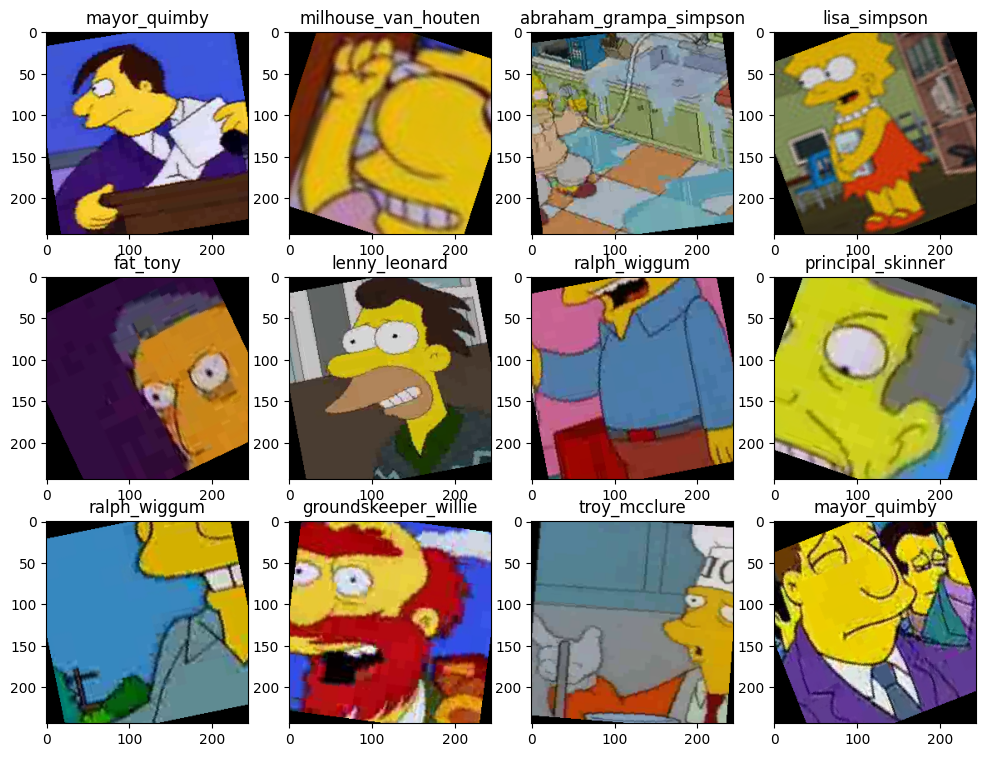

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data, title=train_dataset.classes[l], plt_ax=ax)

In [29]:
def train(model, dataloader, optimizer, criterion, scheduler, n_epochs):
    
    since = time.time()
    
    dataset_size = len(train_dataset)
    
    losses = []
    
    pbar = trange(n_epochs, desc="Epoch:")
    
    for epoch in pbar:
        model.train(True)
        scheduler.step()
        
        running_loss = 0
        running_corrects = 0
        
        for data in tqdm(dataloader, leave=False, desc='iter:'):
            X_batch, y_batch = data
            optimizer.zero_grad()
            outp = model(X_batch)
            preds = outp.argmax(-1)
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_corrects += int(torch.sum(preds==y_batch.data))
            
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects / dataset_size
        
        losses.append(epoch_loss)
            
        pbar.set_description(f'Loss: {epoch_loss:} Acc: {epoch_acc}')
        
    return model, losses

# Baseline Model

In [30]:
class BaselineModel(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [31]:
baseline_model = BaselineModel(n_classes)
print("We will classify {} classes".format(n_classes))
print(f"Model: {baseline_model}")

We will classify 42 classes
Model: BaselineModel(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_feat

In [32]:
optimizer = torch.optim.Adam(baseline_model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [33]:
baseline_model, losses = train(baseline_model, train_loader, optimizer, criterion, scheduler, n_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

iter::   0%|          | 0/328 [00:00<?, ?it/s]

In [34]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(im_size),
            transforms.ToTensor(),
            transforms.Normalize(imnet_mean, imnet_std)
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [35]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [36]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
probs = predict(baseline_model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

RuntimeError: stack expects each tensor to be equal size, but got [3, 275, 244] at entry 0 and [3, 364, 244] at entry 1

In [ ]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("my_first_attempt.csv", index=False)